# ECON 326: Multiple Regression using R and Jupyter

* **Authors**: COMET Team (Emrul Hasan, Jonah Heyl, Shiming Wu)
* **Last Update**: 16 August 2022
---

## Outline

### Prerequisites
* Simple regression
* Data analysis and introduction

### Outcomes

* Understand how the theory of multiple regression models works in practice
* Be able to estimate multiple regression models using R
* Interpret and explain the estimates from multiple regression models
* Understand the relationship between simple linear regressions and similar multiple regressions
* Describe a control variable and regression relationship
* Explore the relationship between controls and causal interpretations of regression model estimates

### Notes

<span id="fn1">[<sup>1</sup>](#fn1s)Statistics Canada, Survey of Financial Security, 2019, 2021. Reproduced and distributed on an "as is" basis with the permission of Statistics Canada.Adapted from Statistics Canada, Survey of Financial Security, 2019, 2021. This does not constitute an endorsement by Statistics Canada of this product.</span>

<span id="fn2">[<sup>2</sup>](#fn2s)Stargazer package is due to: Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer </span>

In [2]:
library(tidyverse) 
library(haven)
library(dplyr)
library(scales)
library(stargazer)
source("functions3.r")

In [3]:
SFS_data <- read_dta("../datasets/SFS_2019_Eng.dta")

## massive data clean-up oh no!
SFS_data <- clean_up_sfs(SFS_data) #renaming things, etc.

#if you want to see, it's in functions3.r

In [4]:
glimpse(SFS_data)

Rows: 10,141
Columns: 102
$ pefamid           <chr> "00014", "00017", "00025", "00032", "00034", "00037"…
$ pweight           <dbl> 634.8358, 671.6546, 1367.6644, 2824.0936, 1106.1072,…
$ age               <fct> 08, 12, 04, 10, 14, 14, 14, 13, 10, 14, 13, 08, 14, …
$ PAS1MRAG          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PAS1MRG1          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PAS1MRG2          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PASR1MFA          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PASR1MR           <dbl+lbl> NA, NA, NA,  2, NA, NA, NA, NA, NA, NA,  2, NA, …
$ pasrbuyg          <fct> 2001 - 2005, NA, NA, 1991 - 2000, 1961 - 1970, 1991 …
$ pasrcnmg          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ pasrcon           <dbl+lbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, …
$ pasrcst           <dbl+lbl>     NA,     NA,     NA, 135000,  14500, 135000, …
$ pasrcurg    

## Part 1: Introducing Multiple Regressions

At this point, you are familiar with the simple regression model and its relationship to the comparison-of-means $t$-test.  However, most econometric analysis don't use simple regression - this is because, in general, economic data and models are far too complicated to be summarized with a single relationship.  One of the features of most economic datasets is a complex, multi-dimensional relationship between different variables.  This leads to the two key motivations for **multiple regression**:

* First, it can improve the *predictive* properties of a regression model, by introducing other variables that play an important econometric role in the relationship being studied.
* Second, it allows the econometrician to *differentiate* the importance of different variables in a relationship.

This second motivation is usually part of **causal analysis** when we believe that our model has an interpretation as a cause-and-effect.  However, even if it does not, it is still useful to understand which variables are "driving" the relationship in the data.

Let's look at the following plot, which depict the relationships between `wealth`, `gender` and `education`.  In the top panel, the colour of each cell is the (average) log of `wealth`.  In the bottom panel, the size of each circle is the number of households in that combination of categories. 

Let's first summarize education into "university" and "non-university". Since it's easier to see the pattern from log wealth, we will calculate log wealth and filter out NaN values.

In [5]:
SFS_data <- SFS_data %>% 
               mutate( 
               Education = case_when(
                     education == "University" ~ "University", # the ~ seperates the original from the new name
                     education == "Non-university post-secondary" ~ "Non-university",
                     education == "High school" ~ "Non-university",
                     education == "Less than high school" ~ "Non-university")) %>%
             mutate(Education = as_factor(Education)) # remember, it's a factor!

glimpse(SFS_data$Education) #we have now data that only considers if someone has finished university or not

 Factor w/ 2 levels "Non-university",..: 1 1 1 1 1 1 1 1 1 1 ...


In [6]:
SFS_data <- SFS_data %>%
               mutate(lnwealth = log(SFS_data$wealth)) # calculate log

Warning message in log(SFS_data$wealth):
“NaNs produced”


Oops NaNs again. We solve this by running the code below.

In [7]:
SFS_data_logged <- SFS_data %>%
                filter(income_before_tax>0) %>% #filters Nans
                filter(wealth>0)  #removes negative values

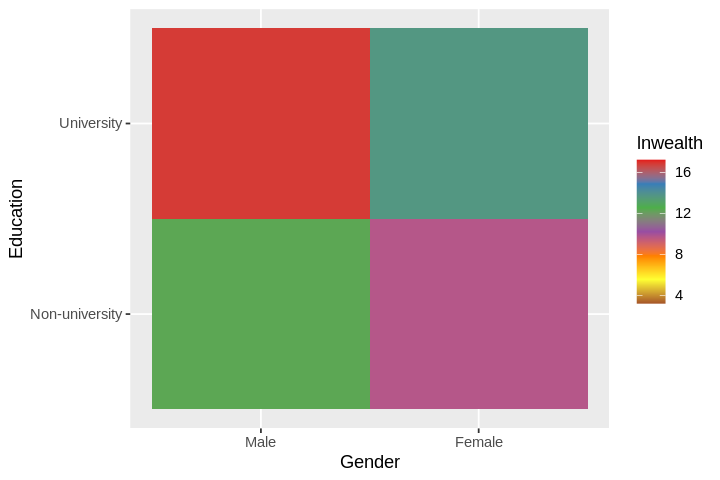

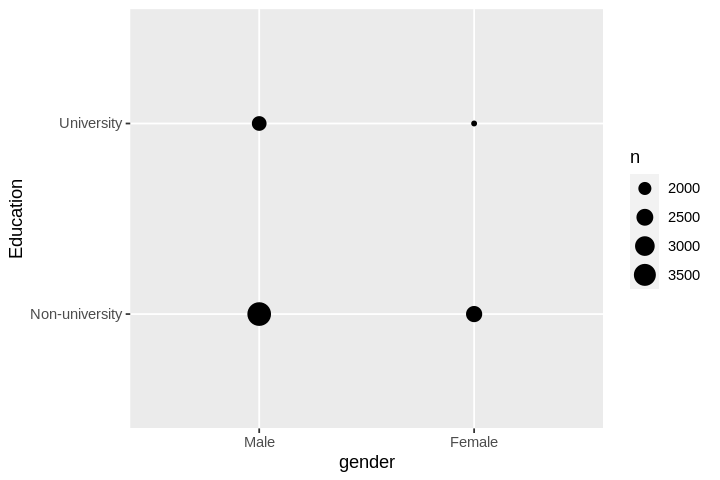

In [8]:
options(repr.plot.width=6,repr.plot.height=4) #controls the image size

f <- ggplot(data = SFS_data_logged, aes(x = gender, y = Education)) + xlab("Gender") + ylab("Education") #defines x and y
f + geom_tile(aes(fill=lnwealth)) + scale_fill_distiller(palette="Set1") #this gives us fancier colours

f <- ggplot(data = SFS_data, aes(x = gender, y = Education)) #defines x and y
f + geom_count() #prints our graph

You can see immediately that there are *three* relationships happening at the same time:

1. There is a relationship between ``wealth`` of households and ``gender`` of main earner
2. There is a relationship between ``wealth`` and ``Education``
3. There is a relationship between ``gender`` and ``Education``

A simple regression can analyze any _one_ of these relationships in isolation, but it cannot assess more than one of them at a time.  For instance, let's look at these regressions.

In [9]:
regression1 <- lm(data = SFS_data, wealth ~ gender) #the effect of gender on wealth
regression2 <- lm(data = SFS_data, wealth ~ Education) #the effect of education on wealth

dummy_gender = as.numeric(SFS_data$gender)-1  # what is this line of code doing?  
# hint, the as.numeric variable treats a factor as a number
# male is 0

regression3 <- lm(data = SFS_data, dummy_gender ~ Education) #the effect of education on gender
# this is actually be a very important regression model called "linear probability"
# we will learn more about it later in the course

stargazer(regression1, regression2, regression3, title="Comparison of Regression Results",
          align = TRUE, type="text", keep.stat = c("n","rsq")) # we will learn more about this command later on!


Comparison of Regression Results
                                Dependent variable:             
                    --------------------------------------------
                                wealth              dummy_gender
                          (1)             (2)           (3)     
----------------------------------------------------------------
genderFemale        -235,285.600***                             
                      (35,393.790)                              
                                                                
EducationUniversity                  717,349.500***   0.046***  
                                      (35,095.260)    (0.010)   
                                                                
Constant            1,128,034.000*** 763,796.000***   0.380***  
                      (22,314.810)    (21,559.430)    (0.006)   
                                                                
--------------------------------------------------------

The problem here is that these results tell us:

* Households with higher education accumulate more wealth (significant and positive coefficient on `EducationUniversity` in (2))
* Among university degrees, the proportion of males is larger than females, with 42.6%(.38+.046) and 57.4%(1-42.6%) respectively. (coefficient on `EducationUniversity` in (3))
* Families led by females accumulates less wealth than the male counterparts. (negative and significant coefficient on `genderFemale` in (1))

This implies that when we measure the gender-wealth gap alone, we are *indirectly* including part of the education-wealth gap as well.  This is bad; the "true" gender-wealth gap is probably lower, but it is being increased because men are more likely to have university degree.

This is both a practical and a theoretical problem.  It's not just about the model, it's also about what we mean when we say "the gender wealth gap".
* If we mean "the difference in wealth between a male and female led family", then the simple regression result is what we want.
* However, this ignores all the other reasons that a male could have a different wealth (education, income, age, etc.)
* If we mean "the difference in wealth between a male and female led family, holding other factors equal," then the simple regression result is not suitable.

The problem is that "holding other factors" equal is a debatable proposition. Which factors? Why? These different ways of computing the gender wealth gap make this topic very complex, contributing to ongoing debate in the economics discipline and in the media about various kinds of gaps (e.g. the education wealth gap). We will revisit this in the exercises.

### Multiple Regression Models

When we measure the gender wealth gap, we do not want to conflate our measurement with the _education wealth gap_. To ensure that these two different gaps are distinguished, we *must* add in some other variables.

A multiple regression model simply adds more explanatory ($X_i$) variables to the model.  In our case, we would take our simple regression model:

$$W_i = \beta_0 + \beta_1 Gender_i + \epsilon_i$$

and augment with a variable which captures ``Education``:

$$W_i = \beta_0 + \beta_1 Gender_i + \color{red}{\beta_2 Edu_i} + \epsilon_i$$

Just as in a simple regression, the goal of estimating a multiple regression model using OLS is to solve the problem:

$$(\hat{\beta_0},\hat{\beta_1},\hat{\beta_2}) = \arg \min_{b_0,b_1,b_2} \sum_{i=1}^{n} (W_i - b_0 - b_1 Gender_i -b_2 Edu_i)^2 = \sum_{i=1}^{n} (e_i)^2$$

In general, you can have any number of explanatory variables in a multiple regression model (as long as it's not larger than $n-1$, your sample size).  However, there are costs to including more variables, which we will learn about more later.  For now, we will focus on building an appropriate model and will worry about the number of variables later.

Adding variables to a regression is easy in R; you use the same command as in simple regression, and just add the new variable to the model. For instance, we can add the variable `Education` like this:

``wealth ~ gender + Education``

Let's see it in action:

In [10]:
multiple_model_1 <- lm(data = SFS_data, wealth ~ gender + Education)

summary(multiple_model_1)


Call:
lm(formula = wealth ~ gender + Education, data = SFS_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2201849  -781517  -433451   244558 29189158 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           865842      25218   34.34  < 2e-16 ***
genderFemale         -268577      34698   -7.74 1.09e-14 ***
EducationUniversity   729837      35031   20.83  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1708000 on 10138 degrees of freedom
Multiple R-squared:  0.04522,	Adjusted R-squared:  0.04503 
F-statistic: 240.1 on 2 and 10138 DF,  p-value: < 2.2e-16


As you can see, there are now three coefficients: one for ``genderFemale``, one for ``EducationUniversity`` and one for the intercept.  The important thing to remember is that these relationships are being calculated *jointly*.  Compare the result above to the two simple regressions we saw earlier:

In [11]:
stargazer(regression1, regression2, multiple_model_1, title="Comparison of Muliple and Simple Regression Results",
          align = TRUE, type="text", keep.stat = c("n","rsq"))

# which column is the multiple regression?


Comparison of Muliple and Simple Regression Results
                                  Dependent variable:              
                    -----------------------------------------------
                                        wealth                     
                          (1)             (2)             (3)      
-------------------------------------------------------------------
genderFemale        -235,285.600***                 -268,577.200***
                      (35,393.790)                   (34,698.120)  
                                                                   
EducationUniversity                  717,349.500*** 729,836.800*** 
                                      (35,095.260)   (35,030.910)  
                                                                   
Constant            1,128,034.000*** 763,796.000*** 865,841.700*** 
                      (22,314.810)    (21,559.430)   (25,217.640)  
                                                               

Notice the difference in the coefficients: *all* of them are different.

> _Think Deeper_: Why would all of these coefficients change?  Why not just the coefficient on ``gender``?

You will also notice that the standard errors are different.  This is an important lesson: including (or not including) variables can change the statistical significance of a result.  This is why it is so important to be very careful when designing regression models and thinking them through: a coefficient estimate is a consequence of the *whole model*, and should not be considered in isolation.

### Interpreting Multiple Regression Coefficients

Interpreting coefficients in a multiple regression is nearly the same as in a simple regression.  After all, our regression equation is:

$$W_i = \beta_0 + \beta_1 Gender_i + \beta_2 Edu_i + \epsilon_i$$

You could (let's pretend for a moment that $Edu_i$ was continuous) calculate:

$$\frac{\partial W_i}{\partial Edu_i} = \beta_2$$

This is the same interpretation as in a simple regression model:
* $\beta_2$ is the change in $W_i$ for a 1-unit change in $Edu_i$.
* As you will see in the exercises, when $Edu_i$ is a dummy, we have the same interpretation as in a simple regression model: the (average) difference in the dependent variable between the two levels of the dummy variable.

However, there is an important difference: we are *holding constant* the other explanatory variables.  That's what the $\partial$ means when we take a derivative.  This was actually always there (since we were holding constant the residual), but now this is something that is directly observable in our data (and in the model we are building).

In [12]:
summary(multiple_model_1)


Call:
lm(formula = wealth ~ gender + Education, data = SFS_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2201849  -781517  -433451   244558 29189158 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           865842      25218   34.34  < 2e-16 ***
genderFemale         -268577      34698   -7.74 1.09e-14 ***
EducationUniversity   729837      35031   20.83  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1708000 on 10138 degrees of freedom
Multiple R-squared:  0.04522,	Adjusted R-squared:  0.04503 
F-statistic: 240.1 on 2 and 10138 DF,  p-value: < 2.2e-16


> **Test your knowledge:**  Based on the results above, how much more wealth do university graduates accumulate, relative to folks with non-university education levels, when we hold gender fixed?

In [13]:
# answer the question above by filling in the number 
answer1 <- 729837       # your answer here

test_1()

Test passed 🌈
[1] "Success!"


### Control Variables: What Do They Mean?

One very common term you may have heard, especially in the context of a multiple regression model, is the idea of a **control variable**.  In a multiple regression model, control variables are just explanatory variables - there is nothing special about how they are included.  However, there *is* something special about how we think about them.

The idea of a control variable refers to how we *think about* a regression model, and in particular, the different variables.  Recall that the interpretation of a coefficient in a multiple regression model is the effect of that variable *holding constant* the other variables.  This is often referred to as **controlling** for the values of those other variables - we are not allowing their relationship with the variable in question, and the outcome variable, to affect our measurement of the result.  This is very common when we are discussing a *cause and effect* relationship - control is essential to these kinds of models.  However, it is also valuable even when we are just thinking about a predictive model.

You can see how this works directly if you think about a multiple regression as a series of "explanations" for the outcome variable.  Each variable, one-by-one "explains" part of the outcome variable.  When we "control" for a variable, we remove the part of the outcome that can be explained by that variable alone.  In terms of our model, this refers to the residual.

However, we must remember that our control variable *also* explains part of the other variables, so we must "control" for it as well.

For instance, our multiple regression:

$$W_i = \beta_0 + \beta_1 Gender_i + \beta_2 Edu_i + \epsilon_i$$

Can be thought of as three, sequential, simple regressions:

$$W_i = \gamma_0 + \gamma_1 Edu_i + u_i$$
$$Gender_i = \gamma_0 + \gamma_1 Edu_i + v_i$$

$$\hat{u_i} = \delta_0 + \delta_1 \hat{v_i} + \eta_i$$

* The first two regressions say: "explain `wealth` and `gender` using `Education` (in simple regressions)"
* The final regression says: "account for whatever is leftover ($\hat{u_i}$) from the `education-wealth` relationship with whatever is leftover from the `gender-wealth` relationship."

This has effectively "isolated" the variation in the data which has to do with ``education`` from the result of the model.

Let's see this in action:

In [14]:
regression1 <- lm(wealth ~ Education, data = SFS_data)
# regress wealth on education

regression2 <- lm(dummy_gender ~ Education, data = SFS_data)
# regress gender on education

temp_data <-  tibble(wealth_leftovers = regression1$residual, gender_leftovers = regression2$residuals)
# take whatever is left-over from those regressions, save it

In [15]:
regression3 <- lm(wealth_leftovers ~ gender_leftovers, data = temp_data)
# regress the leftovers on immigration status

# compare the results with the multiple regression

stargazer(regression1, regression2, regression3, multiple_model_1, title="Comparison of Muliple and Simple Regression Results",
          align = TRUE, type="text", keep.stat = c("n","rsq"))


Comparison of Muliple and Simple Regression Results
                                        Dependent variable:                     
                    ------------------------------------------------------------
                        wealth     dummy_gender wealth_leftovers     wealth     
                         (1)           (2)            (3)              (4)      
--------------------------------------------------------------------------------
genderFemale                                                     -268,577.200***
                                                                  (34,698.120)  
                                                                                
EducationUniversity 717,349.500***   0.046***                    729,836.800*** 
                     (35,095.260)    (0.010)                      (35,030.910)  
                                                                                
gender_leftovers                                -268,577

Look closely at these results.  You will notice that the coefficients on ``gender_leftovers`` in the "control" regression and ``gender`` in the multiple regression are *exactly the same*.

> *Think Deeper:* What if we had done this experiment another way (``wealth`` and ``Education`` on ``gender``)?.  Which coefficients would match?  Why?

This result is a consequence of the **Frisch-Waugh-Lovell theorem** about OLS - a variant of which is referred to as the "regression anatomy" equation.

For our purposes, it does a very useful thing: it gives us a concrete way of thinking about what "controls" are doing: they are "subtracting" part of the variation from both the outcome and other explanatory variables.  In OLS, this is *exactly* what is happening - but for all variables at once! If you don't get it, don't worry about it too much. What is important is now we have a way to disentangle the effects on wealth, weather it be gender or education. 

## Part 2: Hands-On

Now, it's time to continue our investigation of the gender-wealth gap, but now using our multiple regression tools.  As we discussed before, when we investigate the education-wealth gap, we usually want to "hold fixed" different kinds of variables.  We have already seen this, using the `Education` variable to control for the education-wealth gap.  However, there are many more variables we might want to include.

For example, risky investments usually generate more returns and men are typically more willing to take risks - based on research that explores [psychological differences in how risk is processed between men and women](https://journals.sagepub.com/doi/abs/10.1177/0963721411429452) and research that explores [how the perception of a person's gender shapes how risk tolerant or risk adverse a person is thought to be](https://www.mendeley.com/catalogue/5a28efe5-479d-312a-bd80-32e6500a8f1c/). This implies that we may want to control for risky investments in the analysis.

Let's try that now:

In [16]:
risk_regression1 <- lm(data = SFS_data, wealth ~ gender + Education + risk_proxy) #dont worry about what risk proxy is

summary(risk_regression1)


Call:
lm(formula = wealth ~ gender + Education + risk_proxy, data = SFS_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-3373967  -729155  -391705   262694 28858769 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           791902      25612  30.919  < 2e-16 ***
genderFemale         -218123      34753  -6.276 3.61e-10 ***
EducationUniversity   595206      35237  16.891  < 2e-16 ***
risk_proxy           2267520      91119  24.885  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1678000 on 9794 degrees of freedom
  (343 observations deleted due to missingness)
Multiple R-squared:  0.1003,	Adjusted R-squared:    0.1 
F-statistic:   364 on 3 and 9794 DF,  p-value: < 2.2e-16


Once we control for risky investments, what do you see?  How has the gender-wealth gap changed?

Another way is to study financial assets and stocks at the same time, so that we can understand how different categories of assets affect wealth.

In [17]:
risk_regression2 <- lm(wealth ~ gender + Education + financial_asset + stock, data = SFS_data)

summary(risk_regression2)


Call:
lm(formula = wealth ~ gender + Education + financial_asset + 
    stock, data = SFS_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-8724432  -617044  -333117   262582 20996612 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.991e+05  1.921e+04  36.395  < 2e-16 ***
genderFemale        -1.711e+05  2.631e+04  -6.504  8.2e-11 ***
EducationUniversity  4.944e+05  2.668e+04  18.532  < 2e-16 ***
financial_asset      1.598e+00  2.492e-02  64.126  < 2e-16 ***
stock               -1.369e-01  4.159e-02  -3.290    0.001 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1294000 on 10136 degrees of freedom
Multiple R-squared:  0.4522,	Adjusted R-squared:  0.452 
F-statistic:  2092 on 4 and 10136 DF,  p-value: < 2.2e-16


Look closely at this result.  Do you see anything odd or problematic here?

This is a topic we will revise later in this course, but this is **multicollinearity**.  Essentially, what this means is that one of the variables we have added to our model does not add any new information. 

In other words, once we control for the other variables, there's nothing left to explain.  Can you guess what variables are interacting to cause this problem?

Let's dig deeper to see here:

In [18]:
risk_reg1 <- lm(wealth ~ Education + stock, data = SFS_data)
# regress wealth on education and stock

print("Leftovers from wealth ~ education + stock")
head(round(risk_reg1$residuals,2))
#peek at the leftover part of wealth

risk_reg2 <- lm(financial_asset ~ Education + stock, data = SFS_data)
# regress financial asset on education and stock

print("Leftovers from financial asset ~ education + stock")
head(round(risk_reg2$residuals,5))
#peek at the leftover part of financial asset

print("Average Leftovers from financial asset ~ education + stock")
round(mean(risk_reg2$residuals),5)
#look at the average residual!

[1] "Leftovers from wealth ~ education + stock"


1         2         3         4         5         6 
-711542.9 -660792.9 -726837.9  -98042.9 -323517.9  -23972.9

[1] "Leftovers from financial asset ~ education + stock"


1         2         3         4         5         6 
-61044.08 -51269.08 -61264.08 -58969.08 -56019.08 -58399.08

[1] "Average Leftovers from financial asset ~ education + stock"


[1] 0

> *Think Deeper:* Why is "Average Leftovers from financial asset ~ education + stock" equal to 0?

As you can see, the residual from regressing ``financial_asset ~ gender + Education + stock`` is exactly (to machine precision) zero.  In other words, when you "control" for ``gender``, ``Education`` and ``stock`` *there's nothing left to explain* about ``financial_asset``.

If we think about this, it makes sense: you can only have a "stock" if you have financial assets!  So, if I tell you what value "stock" takes on, you will immediately know whether or not I have financial assets or not. 

*Remark: this assumes that the definition of financial assets is mainly stocks. Though this is only true for our data, in the real world financial assets could be bonds, cash, etc.*  

**This argument is bad. By definition the mean of a linear regression is 0 just by pure Math irregardless of the actual variables**

This means that the final step of the multiple regression would be trying to solve this equation:

$$\hat{u_i} = \delta_0 + \delta_1 0 + \eta_i$$

--which does not have a unique solution for $\delta_1$, meaning the regression model isn't well-posed.  R tries to "fix" this problem by getting rid of some variables, but this usually indicates that our model wasn't set-up properly in the first place.

The lesson is that we can't just include controls without thinking about them; we have to pay close attention to their role in our model, and their relationship to other variables.

For example, a *better* way to do this would be to just include ``stock`` instead of both ``financial_assets`` and ``stock``.  

You can also include different sets of controls in your model; often adding different "layers" of controls is a very good way to understand how different variables interact and affect your conclusions.  Here's an example, adding on several different "layers" of controls:

In [19]:
regression1 <- lm(wealth ~ gender, data = SFS_data)
regression2 <- lm(wealth ~ gender + Education, data = SFS_data)
regression3 <- lm(wealth ~ gender + Education + risk_proxy, data = SFS_data)
regression4 <- lm(wealth ~ gender + Education + risk_proxy + business + province + credit_limit, data = SFS_data)

stargazer(regression1, regression2, regression3, regression4, title="Comparison of Controls",
          align = TRUE, type="text", keep.stat = c("n","rsq"))


Comparison of Controls
                                                         Dependent variable:                        
                                  ------------------------------------------------------------------
                                                                wealth                              
                                        (1)              (2)             (3)              (4)       
----------------------------------------------------------------------------------------------------
genderFemale                      -235,285.600***  -268,577.200*** -218,122.600***  -136,676.000*** 
                                    (35,393.790)    (34,698.120)     (34,752.560)     (47,792.370)  
                                                                                                    
EducationUniversity                                729,836.800***   595,206.400***   351,564.800*** 
                                                    (35,030.910)   

A pretty big table!  Often, when we want to focus on just a single variable, we will simplify the table by just explaining which controls are included.  Here's an example which is much easier to read; it uses some formatting tricks which you don't need to worry about right now:

In [20]:
var_omit = c("(province)\\w+","(Education)\\w+") #don't worry about this right now!

stargazer(regression1, regression2, regression3, regression4, title="Comparison of Controls",
          align = TRUE, type="text", keep.stat = c("n","rsq"), 
          omit = var_omit,
          add.lines = list(c("Education Controls", "No", "Yes", "Yes", "Yes"),
                           c("Province Controls", "No", "No", "No", "Yes")))

#this is very advanced code; don't worry about it right now; we will come back to it at the end of the course


Comparison of Controls
                                          Dependent variable:                        
                   ------------------------------------------------------------------
                                                 wealth                              
                         (1)              (2)             (3)              (4)       
-------------------------------------------------------------------------------------
genderFemale       -235,285.600***  -268,577.200*** -218,122.600***  -136,676.000*** 
                     (35,393.790)    (34,698.120)     (34,752.560)     (47,792.370)  
                                                                                     
risk_proxy                                          2,267,520.000*** 1,658,060.000***
                                                      (91,118.800)    (110,410.900)  
                                                                                     
businessNo                    

Notice in the above how the coefficients change when we change the included control variables.  Understanding this kind of variation is really important to interpreting a model, and whether or not the results are credible.  For example - ask yourself why the gender-wealth gap decreases as we include more control variables.  What do you think?

### Omitted Variables

Another important topic comes up in the context of multiple regression: **omitted variables**.  In a simple regression, this didn't really mean anything, but now it does.  When we have a large number of variables in a dataset, which ones do we include in our regression?  All of them?  Some of them?

This is actually a very important problem, since it has crucial implication for the interpretation of our model.  For example, remember Assumption 1?  This is a statement about the "true" model - not what you are actually running.  It can very easily be violated when variables aren't included.

We will revisit this later in the course, since it only really makes sense in the context of causal models, but for now we should pay close attention to which variables we are including and why.  Let's explore this, using the exercises.

## Part 3: Exercises


### Theoretical Activity 1

Suppose you have a regression model that looks like:

$$Y_i = \beta_0 + \beta_1 X_{i} + \beta_2 D_{i} + \epsilon_i$$

Where $D_i$ is a dummy variable.  Recall that Assumption 1 implies that $E[\epsilon_i|D_{i}, X_{i}] = 0$.  Suppose this assumption holds true.  Answer the following:

1.  Compute $E[Y_i|X_i,D_i=1]$ and $E[Y_i|X_i,D_i=0]$
2.  What is the difference between these two terms?
3.  Interpret what the coefficient $\beta_2$ means in this regression, using your answers in 1 and 2.

#### Theoretical Answer 1

**Complete the Exercise**: Carefully write your solutions in the box below.  Use mathematical notation where appropriate, and explain your results.

**TA 1 Answer**: <font color="red">Answer in red here</font>

### Practical Activity 1

To explore the mechanics of multiple regressions, let's return to the analysis that we did in Module 1; that is, let's re-examine the relationship between the gender income gap and education. 

Run a simple regression for the gender income gap (with a single regressor) for each education level. Then, run a multiple regression for the gender income gap that includes education (small e not big e) as a control.

<em>Tested objects:</em> ``reg_LESS`` (simple regression; less than high school), ``reg_HS`` (high school diploma), ``reg_NU`` (Non-university post-secondary), ``reg_U`` (university),  ``reg2`` (multiple regression).

In [38]:
source("functions3.r")

#Less than high school
reg_LESS <- lm(income_before_tax ~ gender, data = filter(SFS_data, education == "Less than high school"))
test_2() #For reg_LESS

#High school diploma
reg_HS <- lm(income_before_tax ~ gender, data = filter(SFS_data, education == "High school"))
test_2.5() #For reg_HS

#Non-university post-secondary
reg_NU <- lm(income_before_tax ~ gender, data = filter(SFS_data, education == "Non-university post-secondary"))
test_3() #For reg_NU


#University
reg_U <- lm(income_before_tax ~ gender, data = filter(SFS_data, education ==  "University"))
test_3.5() #For reg_NU

#Multiple regression
reg2 <- lm(income_before_tax ~ gender + education, data = SFS_data)
test_4() #For reg2

#Table comparing regressions
stargazer(reg_LESS, reg_HS, reg_NU, reg_U, 
          title = "Comparing Conditional Regressions with Multiple Regression", align = TRUE, type = "text", keep.stat = c("n","rsq")) 
summary(reg2)





Test passed 🎊
[1] "Success!"
Test passed 🥇
[1] "Success!"
Test passed 🎊
[1] "Success!"
Test passed 🎉
[1] "Success!"
Test passed 😀
[1] "Success!"

Comparing Conditional Regressions with Multiple Regression
                                 Dependent variable:                    
             -----------------------------------------------------------
                                  income_before_tax                     
                  (1)            (2)            (3)            (4)      
------------------------------------------------------------------------
genderFemale -23,663.400*** -29,719.230*** -33,611.690*** -49,282.000***
              (3,748.467)    (3,181.622)    (3,186.523)    (5,491.501)  
                                                                        
Constant     47,140.710***  81,191.490***  99,335.890***  157,819.100***
              (2,290.419)    (1,951.043)    (1,979.630)    (3,586.096)  
                                                                 


Call:
lm(formula = income_before_tax ~ gender + education, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-199854  -52854  -17252   29784 3147146 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                               52358       3542  14.784  < 2e-16 ***
genderFemale                             -37638       2425 -15.519  < 2e-16 ***
educationHigh school                      31811       4240   7.503 6.78e-14 ***
educationNon-university post-secondary    48532       4096  11.847  < 2e-16 ***
educationUniversity                      100495       3932  25.556  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119400 on 10136 degrees of freedom
Multiple R-squared:  0.09774,	Adjusted R-squared:  0.09739 
F-statistic: 274.5 on 4 and 10136 DF,  p-value: < 2.2e-16


### Short Answer 1
**Prompt**: What variable "value" appears to be missing from the multiple regression in the table? How can we interpret the average income for the group associated with that value? Hint: Dummy Variables

 <font color="red">Answer in red here</font>

### Short Answer 2
Prompt: Compare the coefficient estimates for `gender` across each of the simple regressions. How does the gender income gap appear to vary across education levels? How should we interpret this variation?

<font color="red">Answer in red here</font>

### Short Answer 3
Prompt: Compare the simple regressions' estimates with those of the multiple regression. How does the multiple regression's coefficient estimate on `gender` compare to those estimates in the simple regressions? How can we interpret this? Further, how do we interpret the coefficient estimates on the other regressors in the multiple regression?

<font color="red">Answer in red here</font>

### Activity 2
Consider the multiple regression that we estimated in the previous activity:

$$W_i = \beta_0 + \beta_1 Gender_i + \beta_2 S_i + \epsilon_i$$

Note that $Gender_i$ is `gender` and $S_i$ is `education`.

### Short Answer 4
Prompt: Why might we be skeptical of the argument that $\beta_1$ captures the gender income gap (i.e., the effect of having female as the main earner on household's income, all else being equal)? What can we do to address these concerns?

 <font color="red">Answer in red here</font>

### Short Answer 5
Prompt: Suppose that a member of your research team suggests that we should add `age` as a control in the regression. Do you agree with this group member that this variable would be a good control? Why or why not?

 <font color="red">Answer in red here</font>

Let's first simplify levels of age group using following codes.

In [39]:
#Just run this!
SFS_data <- 
        SFS_data %>%
        mutate(agegr = case_when(
              age == "01" ~ "Under 30",
              age == "02" ~ "Under 30",
              age == "03" ~ "Under 30",
              age == "04" ~ "30-45",
            age == "05" ~ "30-45",
              age == "06" ~ "30-45",
              age == "07" ~ "45-60",
              age == "08" ~ "45-60",
              age == "09" ~ "45-60",
              age == "10" ~ "60-75",
              age == "11" ~ "60-75",
              age == "12" ~ "60-75",
              age == "13" ~ "Above 75",
              age == "14" ~ "Above 75",
              )) %>%
        mutate(agegr = as_factor(agegr))

SFS_data$agegr <- relevel(SFS_data$agegr, ref = "Under 30") #Set "Under 30" as default factor level

Add `agegr` to the given multiple regression and compare it with the model that we estimated in the previous activity.

<em>Tested Objects:</em> `reg3` (the same multiple regression that we estimated before, but with age added as a control).

In [47]:
source("functions3.r")
#Add Age as Control
#Add them in the order: gender, education, age
reg3 <- lm(income_before_tax ~ gender+ education+agegr, data = SFS_data)

#Compare the regressions with and without this control
stargazer(reg2, reg3, 
          title = "Multiple Regressions with and without Age Controls", align = TRUE, type = "text", keep.stat = c("n","rsq")) 

test_5() #For reg3 


Multiple Regressions with and without Age Controls
                                            Dependent variable:     
                                       -----------------------------
                                             income_before_tax      
                                            (1)            (2)      
--------------------------------------------------------------------
genderFemale                           -37,637.690*** -36,300.520***
                                        (2,425.333)    (2,369.344)  
                                                                    
educationHigh school                   31,811.080***  23,452.560*** 
                                        (4,239.993)    (4,242.900)  
                                                                    
educationNon-university post-secondary 48,531.640***  35,905.930*** 
                                        (4,096.373)    (4,150.844)  
                                                   

### Short Answer 6
Prompt: Compare the two regressions in the table above. What happens to the estimated gender income gap when we add age as a control? What might explain this effect?

<font color="red">Answer in red here</font>

### Short Answer 7
Prompt: Suppose that one of your fellow researchers argues that `employment` (employment status) should be added to the multiple regression as a control. That way, they reason, we can account for differences between employed and unemployed workers. Do you agree with their reasoning? Why or why not?

<font color="red">Answer in red here</font>

Let's test this argument directly. Add `employment` as a control to the multiple regression with all previous controls. Estimate this new regression (`reg4`).

In [57]:
source("functions3.r")

reg4 <- lm(income_before_tax ~ gender+ education+agegr+employment, data = SFS_data)

summary(reg4)

test_5.5() 


Call:
lm(formula = income_before_tax ~ gender + education + agegr + 
    employment, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-191458  -47949  -13495   23718 3108542 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                               41225       5375   7.670 1.88e-14 ***
genderFemale                             -29059       2390 -12.160  < 2e-16 ***
educationHigh school                      17992       4296   4.189 2.83e-05 ***
educationNon-university post-secondary    27270       4202   6.489 9.07e-11 ***
educationUniversity                       77334       4060  19.049  < 2e-16 ***
agegr45-60                                72898       4457  16.357  < 2e-16 ***
agegr60-75                                58371       4682  12.468  < 2e-16 ***
agegr30-45                                32722       4588   7.132 1.06e-12 ***
agegrAbove 75                             60900       6006  10.140  

Test passed 🎉
[1] "Success!"


### Short Answer 8
Prompt: What happened when we tried to run the regression with `employment`? Does this "result" agree or disagree with your explanation in Short Answer 7?

<font color="red">Answer in red here</font>

### Activity 3

In the middle of your team's discussion of which controls they should add to the multiple regression (the same one as the previous activity), your roommate bursts into the room and yells "Just add them all!" After a moment of confused silence, the roommate elaborates that it never hurts to add controls as long as they don't "break" the regression (like `employment` and `agegr`). "Data is hard to come by, so we should use as much of it as we can get," he says.

Recall: Below are all of the variables in the dataset.

In [53]:
glimpse(SFS_data) #Run Me!

Rows: 10,141
Columns: 105
$ pefamid           <chr> "00014", "00017", "00025", "00032", "00034", "00037"…
$ pweight           <dbl> 634.8358, 671.6546, 1367.6644, 2824.0936, 1106.1072,…
$ age               <fct> 08, 12, 04, 10, 14, 14, 14, 13, 10, 14, 13, 08, 14, …
$ PAS1MRAG          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PAS1MRG1          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PAS1MRG2          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PASR1MFA          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ PASR1MR           <dbl+lbl> NA, NA, NA,  2, NA, NA, NA, NA, NA, NA,  2, NA, …
$ pasrbuyg          <fct> 2001 - 2005, NA, NA, 1991 - 2000, 1961 - 1970, 1991 …
$ pasrcnmg          <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ pasrcon           <dbl+lbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, …
$ pasrcst           <dbl+lbl>     NA,     NA,     NA, 135000,  14500, 135000, …
$ pasrcurg    

### Short Answer 9
Prompt: Do you agree with your roommate's argument? Why or why not?

<font color="red">Answer in red here</font>

Let's back up our argument with regression analysis. Estimate a regression that has the same controls as `reg3` from the previous activity, but add `pasrbuyg` as a control as well.

<em>Tested Objects:</em> `reg5`.

What is "pasrbuyg"?

In [54]:
dictionary("pasrbuyg") #What goes in here?

[1] "Year property was purchased"

In [63]:
source("functions3.r")
#Add pasrbuyg to regression
#Keep the order (gender, education, agegr, pasrbuyg)
reg5 <- lm(income_before_tax ~ gender+education+agegr+pasrbuyg, data = SFS_data)

#Table comparing regressions with and without ppsort
stargazer(reg3, reg5,
          title = "Multiple Regressions with and without ppsort", align = TRUE, type = "text", keep.stat = c("n","rsq")) 

test_6() #For reg5 


Multiple Regressions with and without ppsort
                                            Dependent variable:     
                                       -----------------------------
                                             income_before_tax      
                                            (1)            (2)      
--------------------------------------------------------------------
genderFemale                           -36,300.520*** -38,141.920***
                                        (2,369.344)    (3,170.831)  
                                                                    
educationHigh school                   23,452.560***  25,394.670*** 
                                        (4,242.900)    (5,990.540)  
                                                                    
educationNon-university post-secondary 35,905.930***  35,158.480*** 
                                        (4,150.844)    (5,836.349)  
                                                         

### Short Answer 10
Prompt: Does the table above suggest that we should add `pasrbuyg` as a control?

<font color="red">Answer in red here</font>

### Short Answer 11
Prompt: What other variables can be added as controls?

<font color="red">Answer in red here</font>